This EDA is about comparing streets so we can check if number of accidents change for similar streets if they have Bicycle Paths vs streets that don't 

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, LineString
from shapely.geometry import Point
from shapely.ops import unary_union
import leafmap

import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

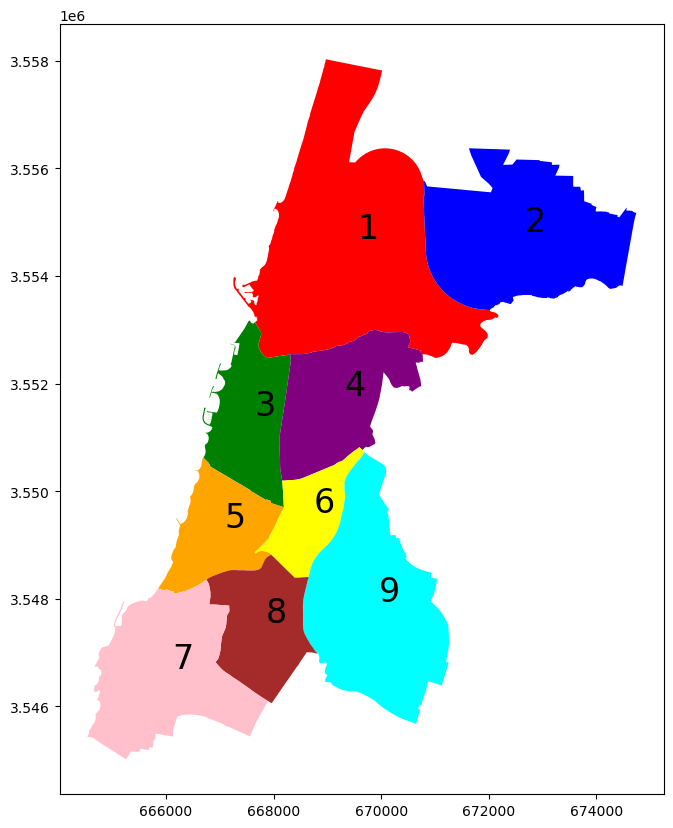

In [3]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)

ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

In [ ]:
# loading ta quarters and bp data
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')

# loading OSMnx and setting up Overpass API for historical data
original_overpass_settings = ox.settings.overpass_settings

# Define the historical date you're interested in (ISO 8601 format)
# For example, January 1st, 2018
historical_date_str = "2018-01-01T00:00:00Z"

# Prepend the date setting to Overpass query settings
# This tells Overpass to use data as of this date
ox.settings.overpass_settings = f'[date:"{historical_date_str}"]{original_overpass_settings}'

print(f"Attempting to fetch map data for Tel Aviv as of {historical_date_str}...")
G_historical = ox.graph_from_place("Tel Aviv, Israel", network_type="drive")

# you can convert your graph to node and edge GeoPandas GeoDataFrames

os_ta_streets_nodes, os_ta_streets_edges = ox.graph_to_gdfs(G_historical)

os_ta_streets_nodes = os_ta_streets_nodes.to_crs('32636')
os_ta_streets_edges = os_ta_streets_edges.to_crs('32636')

display(os_ta_streets_nodes.head(3)), os_ta_streets_nodes.shape

# creating a GeoDataFrame for the edges inside the quarters
bp_in_q = gpd.sjoin(os_ta_streets_edges[['length','geometry']], ta_q[['krova', 'geometry']], how='inner', predicate='intersects')

# dropping duplicate rows based on 'length' 
bp_in_q = bp_in_q.drop_duplicates(subset=['length'])


Attempting to fetch map data for Tel Aviv as of 2018-01-01T00:00:00Z...


,y,x,highway,street_count,ref,geometry
osmid,,,,,,
139693,32.093846,34.790574,traffic_signals,4,NaN,POINT (668968.813 3552240.949)
139698,32.093880,34.791232,NaN,3,NaN,POINT (669030.870 3552245.762)
139707,32.095357,34.778492,NaN,3,NaN,POINT (667825.817 3552389.606)


KeyError: "['oid_shvil', 'shemmikta', 'bp_length', 'bitzua'] not in index"

In [14]:
# --- 1. Load Tel Aviv quarters data ---
# Ensure this file path is correct
ta_q_path = "./csv_tables/TA_Quaters_UTM/Quarters.shp"
try:
    ta_q = gpd.read_file(ta_q_path)
except Exception as e:
    print(f"Error loading ta_q shapefile from {ta_q_path}: {e}")
    print("Please ensure the path is correct and the file exists.")
    raise

ta_q['oidrova'] = pd.to_numeric(ta_q.oidrova, errors='coerce', downcast='integer')
ta_q['krova'] = pd.to_numeric(ta_q.krova, errors='coerce', downcast='integer')

# Ensure ta_q is in the correct CRS (EPSG:32636)
if ta_q.crs is None:
    print("Warning: CRS for ta_q is not set. Assuming EPSG:32636 if UTM, but explicit setting is safer.")
    # For example, if you know it's WGS84 and needs conversion:
    # ta_q = ta_q.set_crs('EPSG:4326').to_crs('EPSG:32636')
elif ta_q.crs != 'EPSG:32636':
    print(f"Converting ta_q CRS from {ta_q.crs} to EPSG:32636")
    ta_q = ta_q.to_crs('EPSG:32636')

# --- 2. Setup for historical data fetching ---
results_dict = {}
years_to_fetch = [2013, 2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024] # Years you want data for

# Store original OSMnx Overpass settings
original_overpass_settings = ox.settings.overpass_settings

# Prepare quarters data for overlay (can be done once if ta_q doesn't change)
# Selecting only 'krova' (quarter identifier) and 'geometry'
quarters_to_process = ta_q[['krova', 'geometry']].copy()

# --- 3. Loop through years, fetch data, and process ---
for year in years_to_fetch:
    historical_date_str = f"{year}-01-01T00:00:00Z"
    print(f"\n--- Processing data for year: {year} (as of {historical_date_str}) ---")
    
    streets_in_quarters_year = None # Initialize for this iteration
    try:
        # Prepend the date setting to Overpass query settings
        ox.settings.overpass_settings = f'[date:"{historical_date_str}"]{original_overpass_settings}'
        
        print(f"Attempting to fetch map data for Tel Aviv as of {historical_date_str}...")
        G_historical = ox.graph_from_place("Tel Aviv, Israel", network_type="drive")
        print(f"Successfully fetched graph for {year}.")
        
        # Convert graph to node and edge GeoDataFrames
        # We only need the edges for this operation
        _, os_ta_streets_edges = ox.graph_to_gdfs(G_historical)
        
        # Reproject edges to UTM EPSG:32636
        os_ta_streets_edges = os_ta_streets_edges.to_crs('EPSG:32636')
        print(f"Edges reprojected to EPSG:32636 for {year}.")

        # Select relevant columns from streets.
        # Common columns from OSMnx include 'osmid', 'length' (original), 'name', 'highway'.
        # Check os_ta_streets_edges.columns if you encounter KeyErrors for missing columns.
        street_columns_to_keep = ['osmid', 'length', 'name', 'highway', 'geometry']
        # Filter to only columns that actually exist in os_ta_streets_edges to prevent KeyErrors
        available_street_columns = [col for col in street_columns_to_keep if col in os_ta_streets_edges.columns]
        if 'geometry' not in available_street_columns: # Ensure geometry is always included
             available_street_columns.append('geometry')

        streets_to_process = os_ta_streets_edges[list(set(available_street_columns))].copy()


        print(f"Splitting streets by quarter boundaries for {year} using overlay...")
        # Perform the overlay (intersection)
        # This operation can be computationally intensive for large datasets.
        streets_in_quarters_year = gpd.overlay(
            streets_to_process,
            quarters_to_process,
            how='intersection',
            keep_geom_type=True  # Ensures we get LineString geometries back
        )
        
        if streets_in_quarters_year.empty:
            print(f"No street segments found intersecting with quarters for {year}.")
        else:
            # The 'length' column from streets_to_process is the length of the *original* unsplit segment.
            # Recalculate the length for these new, potentially shorter, split segments.
            streets_in_quarters_year['segment_length_in_quarter'] = streets_in_quarters_year.geometry.length
            print(f"Successfully split streets by quarter boundaries for {year}.")

        results_dict[year] = streets_in_quarters_year
        print(f"Processed and stored data for {year}.")
        print(f"Shape of stored GeoDataFrame for {year}: {streets_in_quarters_year.shape}")
        if not streets_in_quarters_year.empty:
             print(f"Example of processed data for {year} (first 3 rows):")
             print(streets_in_quarters_year.head(3))


    except Exception as e:
        print(f"An error occurred while processing data for {year}: {e}")
        print("This could be due to Overpass API limitations, network issues, data processing errors (e.g., overlay issues), or invalid geometries.")
        results_dict[year] = None # Store None if processing failed for this year
    
    finally:
        # ALWAYS reset the settings to their original state
        ox.settings.overpass_settings = original_overpass_settings
        print(f"osmnx.settings.overpass_settings reset after processing for {year}.")

# --- 4. Finished ---
print("\n--- All years processed ---")
print(f"Results stored in `results_dict`. Keys: {list(results_dict.keys())}")

# You can now access the GeoDataFrame for each year, e.g.:
for year_processed, data_gdf in results_dict.items():
    print(f"\n--- Data for {year_processed} ---")
    if data_gdf is not None:
        if not data_gdf.empty:
            print(f"Shape: {data_gdf.shape}")
            print("First 3 rows:")
            print(data_gdf.head(3))
            # To get total length of streets per quarter for this year:
            # length_per_krova = data_gdf.groupby('krova')['segment_length_in_quarter'].sum()
            # print("\nTotal street length per krova (quarter):")
            # print(length_per_krova)
        else:
            print("No street segments found within quarters for this year.")
    else:
        print("Processing failed for this year.")


--- Processing data for year: 2013 (as of 2013-01-01T00:00:00Z) ---
Attempting to fetch map data for Tel Aviv as of 2013-01-01T00:00:00Z...
Successfully fetched graph for 2013.
Edges reprojected to EPSG:32636 for 2013.
Splitting streets by quarter boundaries for 2013 using overlay...
Successfully split streets by quarter boundaries for 2013.
Processed and stored data for 2013.
Shape of stored GeoDataFrame for 2013: (12595, 7)
Example of processed data for 2013 (first 3 rows):
    length      osmid   highway         name  krova  \
0   62.120  167691710  tertiary  יהודה המכבי      4   
1   14.150  213434785  tertiary  יהודה המכבי      4   
2  124.639    5118378  tertiary        ויצמן      4   

                                            geometry  \
0  LINESTRING (668968.813 3552240.949, 669030.870...   
1  LINESTRING (668968.813 3552240.949, 668954.635...   
2  LINESTRING (668968.813 3552240.949, 668964.887...   

   segment_length_in_quarter  
0                  62.243925  
1         

In [34]:
years_to_fetch = [2013, 2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024] # Years you want data for
for year in years_to_fetch:
    print(results_dict[year].groupby('krova').segment_length_in_quarter.sum())  # Display the keys of the results dictionary to confirm processing



krova
1    159351.834461
2    149768.645589
3     70687.427697
4     87640.437593
5     71473.656531
6     53623.754984
7    162666.610558
8     93617.713810
9    184322.143422
Name: segment_length_in_quarter, dtype: float64
krova
1    159351.834461
2    149768.645589
3     70687.427697
4     87640.437593
5     71473.656531
6     53623.754984
7    162666.610558
8     93617.713810
9    184322.143422
Name: segment_length_in_quarter, dtype: float64
krova
1    159351.834461
2    149768.645589
3     70687.427697
4     87640.437593
5     71473.656531
6     53623.754984
7    162666.610558
8     93617.713810
9    184322.143422
Name: segment_length_in_quarter, dtype: float64
krova
1    159351.834461
2    149768.645589
3     70687.427697
4     87640.437593
5     71473.656531
6     53623.754984
7    162666.610558
8     93617.713810
9    184322.143422
Name: segment_length_in_quarter, dtype: float64
krova
1    159351.834461
2    149768.645589
3     70687.427697
4     87640.437593
5     71473.656531